## Denoising autoencoder

Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [1]:
# Load packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras import regularizers
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
# Data
# Let's prepare our input data. We're using MNIST digits, and we're discarding the labels 
# (since we're only interested in encoding/decoding the input images).
(x_train, _), (x_test, _) = mnist.load_data()

# We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

# Adding noises
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

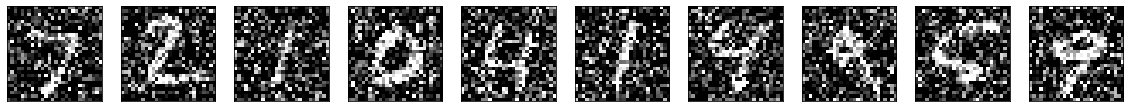

In [4]:
# Show noisy data
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [5]:
# Model
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


In [6]:
# Training
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 8s 133us/step - loss: 0.1836 - val_loss: 0.1244
Epoch 2/100
60000/60000 [==============================] - 5s 86us/step - loss: 0.1195 - val_loss: 0.1107
Epoch 3/100
60000/60000 [==============================] - 5s 87us/step - loss: 0.1123 - val_loss: 0.1093
Epoch 4/100
60000/60000 [==============================] - 5s 86us/step - loss: 0.1086 - val_loss: 0.1102
Epoch 5/100
60000/60000 [==============================] - 5s 85us/step - loss: 0.1062 - val_loss: 0.1072
Epoch 6/100
60000/60000 [==============================] - 5s 86us/step - loss: 0.1046 - val_loss: 0.1052
Epoch 7/100
60000/60000 [==============================] - 5s 91us/step - loss: 0.1034 - val_loss: 0.1029
Epoch 8/100
60000/60000 [==============================] - 5s 87us/step - loss: 0.1025 - val_loss: 0.1013
Epoch 9/100
60000/60000 [==============================] - 5s 85us/step - loss: 0.1015 - val_loss: 0.

60000/60000 [==============================] - 5s 84us/step - loss: 0.0945 - val_loss: 0.0944
Epoch 78/100
60000/60000 [==============================] - 5s 83us/step - loss: 0.0944 - val_loss: 0.0942
Epoch 79/100
60000/60000 [==============================] - 5s 84us/step - loss: 0.0944 - val_loss: 0.0940
Epoch 80/100
60000/60000 [==============================] - 5s 84us/step - loss: 0.0943 - val_loss: 0.0942
Epoch 81/100
60000/60000 [==============================] - 5s 84us/step - loss: 0.0944 - val_loss: 0.0941
Epoch 82/100
60000/60000 [==============================] - 5s 84us/step - loss: 0.0943 - val_loss: 0.0941
Epoch 83/100
60000/60000 [==============================] - 5s 85us/step - loss: 0.0943 - val_loss: 0.0943
Epoch 84/100
60000/60000 [==============================] - 5s 84us/step - loss: 0.0943 - val_loss: 0.0940
Epoch 85/100
60000/60000 [==============================] - 5s 84us/step - loss: 0.0942 - val_loss: 0.0940
Epoch 86/100
60000/60000 [========================

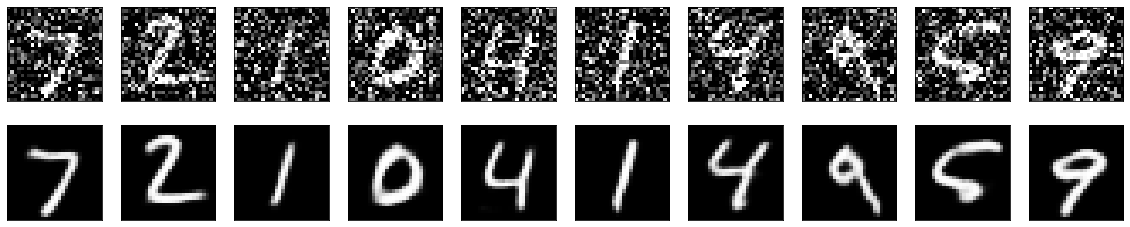

In [7]:
# encode and decode some digits
# note that we take them from the *test* set
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [8]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 32)        0         
__________